In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import dask.array as da
import pyproj
import sys

pd.set_option("display.max_rows", 200)
import pdb

from pycontrails import Flight, Fleet, MetDataset
from pycontrails.core import models
from pycontrails.datalib.ecmwf import ERA5
from pycontrails.physics import geo, thermo, units, constants

# from pycontrails.models.ps_model import PSFlight
# from pycontrails.models.emissions import Emissions
from pycontrails.ext.flight_gen import FlightGen
from pycontrails.models.boxmodel.boxm import Boxm

# from pycontrails.models.dry_advection import DryAdvection
from pycontrails.core.met_var import (
    AirTemperature,
    RelativeHumidity,
    SpecificHumidity,
    EastwardWind,
    NorthwardWind,
    VerticalVelocity,
)

In [2]:
# meteorological parameters
met_params = {
    "air_temperature": 240.0,  # K
    "specific_humidity": 0.001,  # 1
    "relative_humidity": 0.5,  # 1
    "eastward_wind": 0.0,  # m/s
    "northward_wind": 0.0,  # m/s
    "lagrangian_tendency_of_air_pressure": 0.0,  # m/s
}

In [3]:
# flight trajectory parameters
fl_params = {
    "t0_fl": pd.to_datetime("2023-11-10 14:00:00"),  # flight start time
    "rt_fl": pd.Timedelta(minutes=30),  # flight run time
    "ts_fl": pd.Timedelta(minutes=2),  # flight time step
    "ac_type": "A320",  # aircraft type
    "fl0_speed": 100.0,  # m/s
    "fl0_heading": 45.0,  # deg
    "fl0_coords0": (37.5, -97.5, 6500),  # lat, lon, alt [deg, deg, m]
    "sep_dist": (5000, 2000, 0),  # dx, dy, dz [m]
    "n_ac": 1,  # number of aircraft
}

In [4]:
# plume dispersion parameters
plume_params = {
    "dt_integration": pd.Timedelta(minutes=5),  # integration time step
    "max_age": pd.Timedelta(hours=2),  # maximum age of the plume
    "depth": 50.0,  # initial plume depth, [m]
    "width": 50.0,  # initial plume width, [m]
    "shear": 0.005,  # wind shear [1/s]
}

In [5]:
# chemistry sim parameters
chem_params = {
    "t0_chem": pd.to_datetime("2023-11-10 12:00:00"),  # chemistry start time
    "rt_chem": pd.Timedelta(days=5),  # chemistry runtime
    "ts_chem": pd.Timedelta(minutes=5),  # chemistry time step
    "lat_bounds": (37.0, 38.0),  # lat bounds [deg]
    "lon_bounds": (-98.0, -97.0),  # lon bounds [deg]
    "alt_bounds": (6000, 7000),  # alt bounds [m]
    "hres_chem": 0.1,  # horizontal resolution [deg]
    "vres_chem": 500,  # vertical resolution [m]
}

In [6]:
# create lists for lats, lons, alts, and times based on chem params
lats = np.arange(
    chem_params["lat_bounds"][0], chem_params["lat_bounds"][1] + chem_params["hres_chem"], chem_params["hres_chem"]
)

lons = np.arange(
    chem_params["lon_bounds"][0], chem_params["lon_bounds"][1] + chem_params["hres_chem"], chem_params["hres_chem"]
)

alts = np.arange(
    chem_params["alt_bounds"][0], chem_params["alt_bounds"][1] + chem_params["vres_chem"], chem_params["vres_chem"]
)

times = pd.date_range(
    start=chem_params["t0_chem"],
    end=chem_params["t0_chem"] + chem_params["rt_chem"],
    freq=chem_params["ts_chem"],
)


In [7]:
# generate artifical met dataset (boxm currently only supports zero-wind scenarios)
data_vars = {
    param: (
        ["longitude", "latitude", "level", "time"],
        da.full(
            (len(lons), len(lats), len(alts), len(times)),
            value,
            chunks=(len(lons), len(lats), len(alts), 100),
        ),
    )
    for param, value in met_params.items()
}

met = xr.Dataset(
    data_vars,
    coords={"longitude": lons, "latitude": lats, "level": units.m_to_pl(alts), "time": times},
)

met = MetDataset(met)

met

MetDataset with data:

<xarray.Dataset> Size: 27MB
Dimensions:                              (longitude: 11, latitude: 12,
                                          level: 3, time: 1441)
Coordinates:
  * longitude                            (longitude) float64 88B -98.0 ... -97.0
  * latitude                             (latitude) float64 96B 37.0 ... 38.1
  * level                                (level) float64 24B 410.6 440.3 471.8
  * time                                 (time) datetime64[ns] 12kB 2023-11-1...
    air_pressure                         (level) float64 24B 4.106e+04 ... 4....
    altitude                             (level) float64 24B 7e+03 6.5e+03 6e+03
Data variables:
    air_temperature                      (longitude, latitude, level, time) float64 5MB dask.array<chunksize=(11, 12, 3, 100), meta=np.ndarray>
    specific_humidity                    (longitude, latitude, level, time) float64 5MB dask.array<chunksize=(11, 12, 3, 100), meta=np.ndarray>
    relative_humidity                    (longitude, latitude, level, time) float64 5MB dask.array<chunksize=(11, 12, 3, 100), meta=np.ndarray>
    eastward_wind                        (longitude, latitude, level, time) float64 5MB dask.array<chunksize=(11, 12, 3, 100), meta=np.ndarray>
    northward_wind                       (longitude, latitude, level, time) float64 5MB dask.array<chunksize=(11, 12, 3, 100), meta=np.ndarray>
    lagrangian_tendency_of_air_pressure  (longitude, latitude, level, time) float64 5MB dask.array<chunksize=(11, 12, 3, 100), meta=np.ndarray>

In [8]:
# instantiate FlightGen object
fl_gen = FlightGen(met, fl_params, plume_params, chem_params)

In [9]:
fl = fl_gen.traj_gen()

fl

   longitude  latitude  altitude                time
0 -97.500000   37.5000      6500 2023-11-10 14:00:00
1 -96.038172   38.6377      6500 2023-11-10 14:30:00


[Flight [4 keys x 5 length, 3 attributes]
 	Keys: longitude, latitude, altitude, time
 	Attributes:
 	time                [2023-11-10 14:00:00, 2023-11-10 14:08:00]
 	longitude           [-97.5, -97.113]
 	latitude            [37.5, 37.805]
 	altitude            [6500.0, 6500.0]
 	flight_id           0
 	aircraft_type       A320
 	crs                 EPSG:4326]

In [10]:
# estimate fuel burn and emissions using ps_model and emissions model
fl = fl_gen.calc_fb_emissions()


/home/ktait98/pycontrails_kt/pycontrails/ext/flight_gen.py:130: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  flights[i].dataframe[column] = flights[i].dataframe[column].fillna(method='ffill')


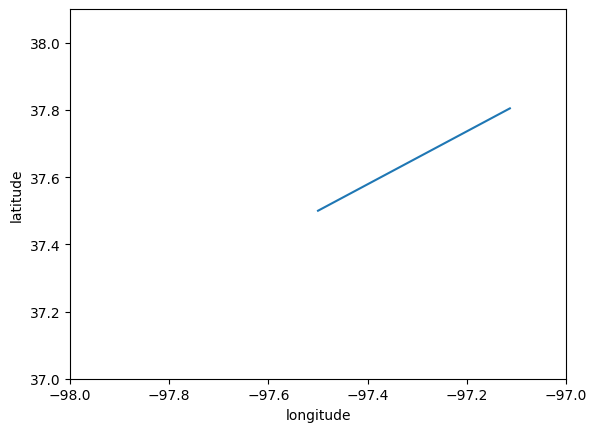

In [11]:
# visualise the fleet
ax = plt.axes()
ax.set_xlim([lons[0], lons[-1]])
ax.set_ylim([lats[0], lats[-1]])
for i in fl:
    i.plot(ax=ax)

In [12]:
# simulate plume dispersion/advection using dry advection model
fl_df, pl_df = fl_gen.sim_plumes()

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 30)

fl_df

/home/ktait98/pycontrails_kt/pycontrails/ext/flight_gen.py:184: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  flights[i][column] = flights[i][column].fillna(method='ffill')


,longitude,latitude,altitude,time,air_temperature,specific_humidity,true_airspeed,flight_id,aircraft_mass,engine_efficiency,fuel_flow,fuel_burn,thrust,rocd,fuel_flow_per_engine,...,nvpm_number,CO2,H2O,SO2,nvPM,NO,NO2,CO,HCHO,CH3CHO,C2H4,C3H6,C2H2,BENZENE,waypoint
0,-97.500000,37.500000,6500.0,2023-11-10 14:00:00,240.0,0.001,100.143033,0.0,57854.842403,0.187523,0.533535,64.024198,43090.003692,0.0,0.266767,...,4.924946e+16,6.734250e-07,2.621243e-07,1.790117e-10,4.930801e-12,1.716672e-09,9.035116e-11,9.427356e-10,1.813966e-12,6.046555e-13,2.267458e-12,6.046555e-13,6.046555e-13,3.023277e-13,0
1,-97.403300,37.576153,6500.0,2023-11-10 14:02:00,240.0,0.001,100.091513,0.0,57790.818206,0.187447,0.532862,63.943408,43040.267831,0.0,0.266431,...,4.913219e+16,6.729214e-07,2.619283e-07,1.788778e-10,4.917993e-12,1.713843e-09,9.020228e-11,9.446619e-10,1.820674e-12,6.068913e-13,2.275842e-12,6.068913e-13,6.068913e-13,3.034457e-13,1
2,-97.306599,37.652307,6500.0,2023-11-10 14:04:00,240.0,0.001,100.039930,0.0,57726.874797,0.187371,0.532190,63.862799,42990.670032,0.0,0.266095,...,4.901531e+16,6.724196e-07,2.617330e-07,1.787445e-10,4.905230e-12,1.711024e-09,9.005390e-11,9.465918e-10,1.827403e-12,6.091342e-13,2.284253e-12,6.091342e-13,6.091342e-13,3.045671e-13,2
3,-97.209899,37.728460,6500.0,2023-11-10 14:06:00,240.0,0.001,99.988285,0.0,57663.011999,0.187310,0.531782,63.813873,42966.070409,0.0,0.265891,...,4.894547e+16,6.722515e-07,2.616675e-07,1.786998e-10,4.898657e-12,1.709651e-09,8.998163e-11,9.479761e-10,1.831928e-12,6.106427e-13,2.289910e-12,6.106427e-13,6.106427e-13,3.053214e-13,3
4,-97.113198,37.804613,6500.0,2023-11-10 14:08:00,240.0,0.001,99.988285,0.0,57599.198125,0.187310,0.531782,63.813873,42966.070409,0.0,0.265891,...,4.894547e+16,6.722515e-07,2.616675e-07,1.786998e-10,4.898657e-12,1.709651e-09,8.998163e-11,9.479761e-10,1.831928e-12,6.106427e-13,2.289910e-12,6.106427e-13,6.106427e-13,3.053214e-13,4


In [13]:
# fl_gen.anim_fl(fl_df, pl_df)

In [14]:
# convert plume dataframe to EMI geospatial xarray dataset
emi = fl_gen.plume_to_grid(lats, lons, alts, times)

Processing time:  2023-11-10 14:05:00


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Processing time:  2023-11-10 14:10:00


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing time:  2023-11-10 14:15:00


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing time:  2023-11-10 14:20:00


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing time:  2023-11-10 14:25:00


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing time:  2023-11-10 14:30:00


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing time:  2023-11-10 14:35:00


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing time:  2023-11-10 14:40:00


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing time:  2023-11-10 14:45:00


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing time:  2023-11-10 14:50:00


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing time:  2023-11-10 14:55:00


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing time:  2023-11-10 15:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing time:  2023-11-10 15:05:00


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing time:  2023-11-10 15:10:00


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing time:  2023-11-10 15:15:00


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing time:  2023-11-10 15:20:00


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing time:  2023-11-10 15:25:00


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing time:  2023-11-10 15:30:00


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing time:  2023-11-10 15:35:00


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing time:  2023-11-10 15:40:00


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing time:  2023-11-10 15:45:00


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing time:  2023-11-10 15:50:00


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing time:  2023-11-10 15:55:00


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing time:  2023-11-10 16:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing time:  2023-11-10 16:05:00


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
# init boxm simulation and generate chemistry dataset
boxm = Boxm(met=met, params=chem_params)

/home/ktait98/miniconda3/envs/contrails/lib/python3.12/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [16]:
# run boxm simulation
chem = boxm.eval(emi)

/home/ktait98/pycontrails_kt/pycontrails/models/boxmodel/boxm.py:163: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self.boxm_ds["Y"] = (["time", "level", "longitude", "latitude", "species"], da.zeros((self.boxm_ds.dims["time"], self.boxm_ds.dims["level"], self.boxm_ds.dims["longitude"], self.boxm_ds.dims["latitude"], self.boxm_ds.dims["species"])))
/home/ktait98/pycontrails_kt/pycontrails/models/boxmodel/boxm.py:165: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self.boxm_ds["Y_orig"] = (["time", "level", "longitude", "latitude", "species"], da.zeros((self.boxm_ds.dims["time"], self.boxm_

<xarray.Dataset> Size: 3GB
Dimensions:          (time: 1441, cell: 396, species: 219, emi_species: 9,
                      flux_rates: 130)
Coordinates:
  * time             (time) datetime64[ns] 12kB 2023-11-10T12:00:00 ... 2023-...
    air_pressure     (cell) float64 3kB dask.array<chunksize=(396,), meta=np.ndarray>
    altitude         (cell) float64 3kB dask.array<chunksize=(396,), meta=np.ndarray>
  * species          (species) <U10 9kB 'O1D' 'O' 'OH' ... 'EMPOA' 'P2007'
  * emi_species      (emi_species) <U7 252B 'NO' 'NO2' 'CO' ... 'C2H2' 'BENZENE'
    level            (cell) float64 3kB 410.6 410.6 410.6 ... 471.8 471.8 471.8
    longitude        (cell) float64 3kB -98.0 -98.0 -98.0 ... -97.0 -97.0 -97.0
    latitude         (cell) float64 3kB 37.0 37.1 37.2 37.3 ... 37.9 38.0 38.1
Dimensions without coordinates: cell, flux_rates
Data variables:
    air_temperature  (time, cell) float64 5MB dask.array<chunksize=(1441, 396), meta=np.ndarray>
    M                (time, cell) fl

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


/tmp/ipykernel_202175/157807295.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


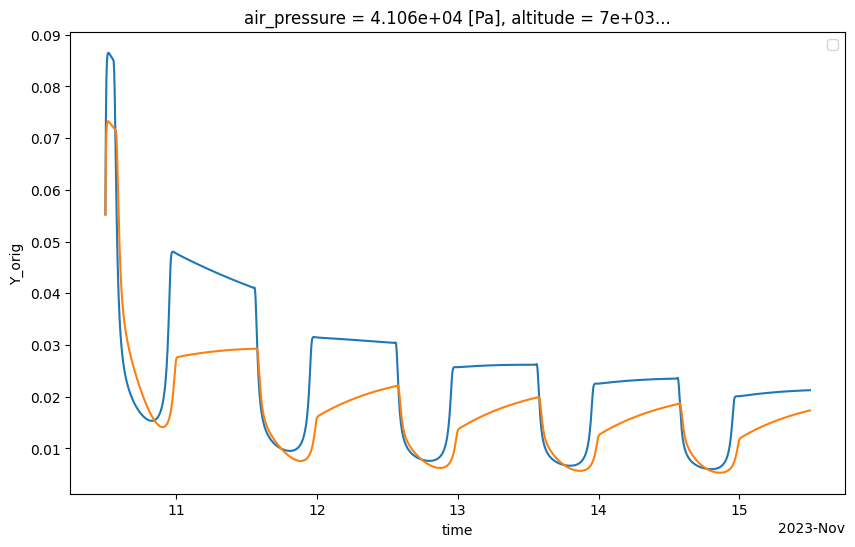

In [21]:
plt.figure(figsize=(10, 6))  # Optional: Adjust figure size

boxm.boxm_ds["Y"].sel(species="NO2", cell=0).plot()
boxm.boxm_ds["Y_orig"].sel(species="NO2", cell=0).plot()
plt.legend()
plt.show()